#Portfolio Analysis

In [49]:
# Import initial libraries
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import alpaca_trade_api as tradeapi
import dash
import dash_core_components as dcc
import dash_html_components as html
# from dash import html
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from MCForecastTools import MCSimulation
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)
# Import nothing

In [50]:
#Read the Holdings file

portfolio_df = pd.read_excel('Holdings.xlsx', sheet_name='Portfolio', parse_dates=True)
portfolio_df.head(10)

,Acquisition Date,Ticker,Quantity,Unit Cost,Cost Basis,Start of Year
0,2019-02-07,AAPL,125,43.50,5437.50,2020-12-31
1,2019-02-07,JNJ,100,132.50,13250.00,2020-12-31
2,2019-02-07,MCD,100,175.20,17520.00,2020-12-31
3,2019-02-07,MTCH,600,55.80,33480.00,2020-12-31
4,2019-02-07,NFLX,75,345.40,25905.00,2020-12-31
5,2019-02-07,WMT,125,149.35,18668.75,2020-12-31
6,2019-02-07,FB,150,165.50,24825.00,2020-12-31
7,2019-02-07,TWTR,225,30.31,6819.75,2020-12-31


In [51]:
# Load .env environment variables
from dotenv import load_dotenv
load_dotenv("api.env")

True

In [52]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [53]:
#Setup Alpaca to get Data
# Set the tickers and add SPY
portfolio_tickers =portfolio_df['Ticker'].to_list()
tickers = portfolio_df['Ticker'].to_list()
spy_ticker='SPY'
tickers.append(spy_ticker)

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes 
start_date = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

#For YTD Calcs
#end_last_year = datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))
end_last_year = datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))


# Set limit_rows to 1000 to retreive the maximum amount of rows
limit_rows = 1000

# Get 1 year's worth of historical data for Tesla and Coca-Cola
# YOUR CODE HERE!
df_ticker = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display sample data
df_ticker.head(10)

AAPL                                        \
                             open      high     low     close    volume   
time                                                                      
2019-01-02 00:00:00-05:00  154.89  158.8500  154.23  157.5225  27803621   
2019-01-03 00:00:00-05:00  143.98  145.7200  142.00  142.2900  82418448   
2019-01-04 00:00:00-05:00  144.53  148.5499  143.80  148.1200  51267225   
2019-01-07 00:00:00-05:00  148.70  148.8300  145.90  147.9100  49982480   
2019-01-08 00:00:00-05:00  149.56  151.8200  148.52  150.6300  36592406   
2019-01-09 00:00:00-05:00  151.29  154.5300  149.63  153.3700  40827842   
2019-01-10 00:00:00-05:00  152.50  153.9700  150.86  153.5500  32553301   
2019-01-11 00:00:00-05:00  152.88  153.7000  151.51  152.0534  22850904   
2019-01-14 00:00:00-05:00  150.85  151.2700  149.22  149.7600  26038136   
2019-01-15 00:00:00-05:00  150.27  153.3900  150.05  152.9500  25862287   

                               FB                                        ...  \
                             open    high     low     close      volume  ...   
time                                                                     ...   
2019-01-02 00:00:00-05:00  128.99  137.51  128.56  135.4100  25465924.0  ...   
2019-01-03 00:00:00-05:00  134.69  137.17  131.12  131.8902  18011900.0  ...   
2019-01-04 00:00:00-05:00  134.01  138.00  133.75  137.9400  23927539.0  ...   
2019-01-07 00:00:00-05:00  137.45  138.87  135.91  138.2300  16261533.0  ...   
2019-01-08 00:00:00-05:00  139.89  143.14  139.54  142.5843  22239823.0  ...   
2019-01-09 00:00:00-05:00  142.95  144.70  141.27  144.2500  18404347.0  ...   
2019-01-10 00:00:00-05:00  143.08  144.56  140.84  144.1500  13885316.0  ...   
2019-01-11 00:00:00-05:00  143.15  145.36  142.57  143.7205  10819759.0  ...   
2019-01-14 00:00:00-05:00  142.08  146.57  141.27  145.6300  17231093.0  ...   
2019-01-15 00:00:00-05:00  146.01  150.68  145.99  148.8200  21340466.0  ...   

                            TWTR                                        WMT  \
                            open    high    low    close      volume   open   
time                                                                          
2019-01-02 00:00:00-05:00  28.26  28.987  27.87  28.7950  13105854.0  91.64   
2019-01-03 00:00:00-05:00  28.38  29.180  27.95  28.0301  17765868.0  93.21   
2019-01-04 00:00:00-05:00  28.39  30.100  28.31  29.9000  19324901.0  93.21   
2019-01-07 00:00:00-05:00  30.20  31.380  28.66  31.3300  16539085.0  93.62   
2019-01-08 00:00:00-05:00  31.70  32.050  30.91  31.7600  14442336.0  95.06   
2019-01-09 00:00:00-05:00  31.80  32.400  31.54  32.2100  13441464.0  95.71   
2019-01-10 00:00:00-05:00  33.08  33.500  32.26  33.0600  25752890.0  93.88   
2019-01-11 00:00:00-05:00  32.85  33.200  32.43  32.7700  14583000.0  94.99   
2019-01-14 00:00:00-05:00  32.38  32.750  32.12  32.3700   8225439.0  94.48   
2019-01-15 00:00:00-05:00  32.51  33.350  32.45  32.9650  12816415.0  95.47   

                                                                
                             high      low    close     volume  
time                                                            
2019-01-02 00:00:00-05:00  93.650  91.6400  93.1699  6776234.0  
2019-01-03 00:00:00-05:00  94.710  92.8700  93.0200  7217268.0  
2019-01-04 00:00:00-05:00  93.660  92.6900  93.3500  6090152.0  
2019-01-07 00:00:00-05:00  95.170  93.1800  94.5800  6600133.0  
2019-01-08 00:00:00-05:00  95.755  93.9100  95.2800  5694991.0  
2019-01-09 00:00:00-05:00  96.140  94.7700  94.9000  5310385.0  
2019-01-10 00:00:00-05:00  94.950  93.1201  94.8500  6505921.0  
2019-01-11 00:00:00-05:00  95.290  94.5500  94.7900  4324471.0  
2019-01-14 00:00:00-05:00  95.450  94.2800  95.0500  4678636.0  
2019-01-15 00:00:00-05:00  96.600  95.3800  96.2100  5801137.0  

[10 rows x 45 columns]

In [54]:
# Create and empty DataFrame for closing prices

df_closing_prices = pd.DataFrame()
for ticker in tickers:
    df_closing_prices[ticker]=df_ticker[ticker]['close']
    
# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date
df_closing_prices.index.name='Date'
df_closing_prices.tail()    

,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR,SPY
Date,,,,,,,,,
2021-11-04,150.960,164.92,253.49,156.96,668.40,151.28,335.980,53.655,466.86
2021-11-05,151.240,163.42,254.65,160.73,645.72,150.23,341.130,53.140,468.49
2021-11-08,150.450,162.88,253.13,155.83,651.44,149.27,338.530,54.090,468.97
2021-11-09,150.830,162.51,252.65,155.52,655.94,149.84,335.400,53.700,467.38
2021-11-10,149.125,163.62,251.66,155.31,652.36,149.03,331.935,53.480,466.90


In [55]:
df_closing_prices

,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR,SPY
Date,,,,,,,,,
2019-01-02,157.5225,127.680,176.07,42.32,267.67,93.1699,135.4100,28.7950,249.89
2019-01-03,142.2900,126.214,175.01,41.14,271.91,93.0200,131.8902,28.0301,244.46
2019-01-04,148.1200,127.830,178.30,43.02,297.47,93.3500,137.9400,29.9000,252.41
2019-01-07,147.9100,127.140,180.27,43.34,316.63,94.5800,138.2300,31.3300,254.40
2019-01-08,150.6300,129.850,180.67,44.73,320.39,95.2800,142.5843,31.7600,256.65
...,...,...,...,...,...,...,...,...,...
2021-11-04,150.9600,164.920,253.49,156.96,668.40,151.2800,335.9800,53.6550,466.86
2021-11-05,151.2400,163.420,254.65,160.73,645.72,150.2300,341.1300,53.1400,468.49
2021-11-08,150.4500,162.880,253.13,155.83,651.44,149.2700,338.5300,54.0900,468.97


In [56]:
# Grab the latest stock close price

df_close_latest = df_closing_prices.iloc[-1].to_frame('Last Close')
df_close_latest.index.name='Ticker'
df_close_latest

,Last Close
Ticker,
AAPL,149.125
JNJ,163.620
MCD,251.660
MTCH,155.310
NFLX,652.360
WMT,149.030
FB,331.935
TWTR,53.480
SPY,466.900


In [57]:
#get the End of Last year Closing price
df_close_YTD_start = df_closing_prices.loc[end_last_year].to_frame('YTD Close')
df_close_YTD_start.index.name="Ticker"
df_close_YTD_start

,YTD Close
Ticker,
AAPL,132.58
JNJ,157.23
MCD,214.57
MTCH,151.19
NFLX,540.71
WMT,144.09
FB,273.20
TWTR,54.14
SPY,373.85


In [58]:
portfolio_df.set_index(['Ticker'], inplace=True)

portfolio_df.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year
Ticker,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31
MCD,2019-02-07,100,175.2,17520.0,2020-12-31
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31


In [59]:
# Merge the portfolio dataframe with the  close dataframe; they are being joined by their indexes.

merged_portfolio = pd.merge(portfolio_df, df_close_latest, left_index=True, right_index=True)
merged_portfolio.index.name="Ticker"
merged_portfolio.head(10)

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close
Ticker,,,,,,
AAPL,2019-02-07,125,43.50,5437.50,2020-12-31,149.125
JNJ,2019-02-07,100,132.50,13250.00,2020-12-31,163.620
MCD,2019-02-07,100,175.20,17520.00,2020-12-31,251.660
MTCH,2019-02-07,600,55.80,33480.00,2020-12-31,155.310
NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,652.360
WMT,2019-02-07,125,149.35,18668.75,2020-12-31,149.030
FB,2019-02-07,150,165.50,24825.00,2020-12-31,331.935
TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,53.480


In [60]:
# The below creates a new column which is the ticker return; takes the latest adjusted close for each position
# and divides that by the initial share cost.

merged_portfolio['Ticker Return'] = merged_portfolio['Last Close'] / merged_portfolio['Unit Cost'] - 1
merged_portfolio


,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return
Ticker,,,,,,,
AAPL,2019-02-07,125,43.50,5437.50,2020-12-31,149.125,2.428161
JNJ,2019-02-07,100,132.50,13250.00,2020-12-31,163.620,0.234868
MCD,2019-02-07,100,175.20,17520.00,2020-12-31,251.660,0.436416
MTCH,2019-02-07,600,55.80,33480.00,2020-12-31,155.310,1.783333
NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,652.360,0.888709
WMT,2019-02-07,125,149.35,18668.75,2020-12-31,149.030,-0.002143
FB,2019-02-07,150,165.50,24825.00,2020-12-31,331.935,1.005650
TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,53.480,0.764434


In [61]:
df_spy_closing_prices=df_closing_prices['SPY'].to_frame('SPY Closes')
df_spy_closing_prices.index = df_spy_closing_prices.index.astype('datetime64[ns]')
df_spy_closing_prices.index.name='Date'
df_spy_closing_prices

,SPY Closes
Date,
2019-01-02,249.89
2019-01-03,244.46
2019-01-04,252.41
2019-01-07,254.40
2019-01-08,256.65
...,...
2021-11-04,466.86
2021-11-05,468.49
2021-11-08,468.97


In [62]:
#merged_portfolio['Acquisition Date'] = merged_portfolio['Acquisition Date'].dt.tz_localize('America/New_York').dt.tz_convert('America/New_York')

In [63]:
# Here we are merging the new dataframe with the sp500 adjusted closes since the sp start price based on 
# each ticker's acquisition date and sp500 close date.

merged_portfolio_sp = pd.merge(merged_portfolio, df_spy_closing_prices, left_on='Acquisition Date', right_index=True)
merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes
Ticker,,,,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31,149.125,2.428161,269.97
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,163.620,0.234868,269.97
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,251.660,0.436416,269.97
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31,155.310,1.783333,269.97
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,652.360,0.888709,269.97


In [64]:
# This new column determines what SP 500 equivalent purchase would have been at purchase date of stock.
merged_portfolio_sp['Equiv SPY Shares'] = merged_portfolio_sp['Cost Basis'] / merged_portfolio_sp['SPY Closes']
merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares
Ticker,,,,,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31,149.125,2.428161,269.97,20.141127
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,163.620,0.234868,269.97,49.079527
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,251.660,0.436416,269.97,64.896100
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31,155.310,1.783333,269.97,124.013779
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,652.360,0.888709,269.97,95.955106


In [65]:
df_close_latest.loc['SPY']

Last Close    466.9
Name: SPY, dtype: float64

In [66]:
df_closing_prices.iloc[-1]['SPY']

466.9

In [67]:
# We are joining the developing dataframe with the sp500 closes again, this time with the latest close for SP.
merged_portfolio_sp['SPY Latest Close'] =  df_closing_prices.iloc[-1]['SPY']

merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close
Ticker,,,,,,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31,149.125,2.428161,269.97,20.141127,466.9
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,163.620,0.234868,269.97,49.079527,466.9
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,251.660,0.436416,269.97,64.896100,466.9
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31,155.310,1.783333,269.97,124.013779,466.9
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,652.360,0.888709,269.97,95.955106,466.9


In [68]:
# Percent return of SP from acquisition date of position through latest trading day.
merged_portfolio_sp['SP Return'] = merged_portfolio_sp['SPY Latest Close'] / merged_portfolio_sp['SPY Closes'] - 1

# This is a new column which takes the tickers return and subtracts the sp 500 equivalent range return.
merged_portfolio_sp['Abs. Return Compare'] = merged_portfolio_sp['Ticker Return'] - merged_portfolio_sp['SP Return']

# This is a new column where we calculate the ticker's share value by multiplying the original quantity by the latest close.
merged_portfolio_sp['Ticker Share Value'] = merged_portfolio_sp['Quantity'] * merged_portfolio_sp['Last Close']

# We calculate the equivalent SP 500 Value if we take the original SP shares * the latest SP 500 share price.
merged_portfolio_sp['SPY Value'] = merged_portfolio_sp['Equiv SPY Shares'] * merged_portfolio_sp['SPY Latest Close']

# This is a new column where we take the current market value for the shares and subtract the SP 500 value.
merged_portfolio_sp['Abs Value Compare'] = merged_portfolio_sp['Ticker Share Value'] - merged_portfolio_sp['SPY Value']

# This column calculates profit / loss for stock position.
merged_portfolio_sp['Stock Gain / (Loss)'] = merged_portfolio_sp['Ticker Share Value'] - merged_portfolio_sp['Cost Basis']

# This column calculates profit / loss for SP 500.
merged_portfolio_sp['SPY Gain / (Loss)'] = merged_portfolio_sp['SPY Value'] - merged_portfolio_sp['Cost Basis']

merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss)
Ticker,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31,149.125,2.428161,269.97,20.141127,466.9,0.729451,1.698709,18640.625,9403.892099,9236.732901,13203.125,3966.392099
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,163.620,0.234868,269.97,49.079527,466.9,0.729451,-0.494583,16362.000,22915.231322,-6553.231322,3112.000,9665.231322
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,251.660,0.436416,269.97,64.896100,466.9,0.729451,-0.293036,25166.000,30299.988888,-5133.988888,7646.000,12779.988888
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31,155.310,1.783333,269.97,124.013779,466.9,0.729451,1.053882,93186.000,57902.033559,35283.966441,59706.000,24422.033559
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,652.360,0.888709,269.97,95.955106,466.9,0.729451,0.159257,48927.000,44801.439049,4125.560951,23022.000,18896.439049


In [69]:
# Merge the overall dataframe with the adj close start of year dataframe for YTD tracking of tickers.
# Should not need to do the outer join;

merged_portfolio_sp_YTD = pd.merge(merged_portfolio_sp, df_close_YTD_start, left_index=True, right_index=True)
# , how='outer'
#merged_portfolio_sp_YTD.rename(columns={'2020-12-31 00:00:00-05:00':'SPY YTD Start Close'}, inplace=True)
merged_portfolio_sp_YTD.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close
Ticker,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31,149.125,2.428161,269.97,20.141127,466.9,0.729451,1.698709,18640.625,9403.892099,9236.732901,13203.125,3966.392099,132.58
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,163.620,0.234868,269.97,49.079527,466.9,0.729451,-0.494583,16362.000,22915.231322,-6553.231322,3112.000,9665.231322,157.23
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,251.660,0.436416,269.97,64.896100,466.9,0.729451,-0.293036,25166.000,30299.988888,-5133.988888,7646.000,12779.988888,214.57
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31,155.310,1.783333,269.97,124.013779,466.9,0.729451,1.053882,93186.000,57902.033559,35283.966441,59706.000,24422.033559,151.19
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,652.360,0.888709,269.97,95.955106,466.9,0.729451,0.159257,48927.000,44801.439049,4125.560951,23022.000,18896.439049,540.71


In [70]:
# We are joining the developing dataframe with the sp500 closes again, this time with the latest close for SP.
merged_portfolio_sp_YTD['SPY YTD Close'] =  df_closing_prices.loc[end_last_year]['SPY']

merged_portfolio_sp_YTD.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close,SPY YTD Close
Ticker,,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31,149.125,2.428161,269.97,20.141127,466.9,0.729451,1.698709,18640.625,9403.892099,9236.732901,13203.125,3966.392099,132.58,373.85
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,163.620,0.234868,269.97,49.079527,466.9,0.729451,-0.494583,16362.000,22915.231322,-6553.231322,3112.000,9665.231322,157.23,373.85
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,251.660,0.436416,269.97,64.896100,466.9,0.729451,-0.293036,25166.000,30299.988888,-5133.988888,7646.000,12779.988888,214.57,373.85
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31,155.310,1.783333,269.97,124.013779,466.9,0.729451,1.053882,93186.000,57902.033559,35283.966441,59706.000,24422.033559,151.19,373.85
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,652.360,0.888709,269.97,95.955106,466.9,0.729451,0.159257,48927.000,44801.439049,4125.560951,23022.000,18896.439049,540.71,373.85


In [71]:
merged_portfolio_sp_YTD.dtypes

Acquisition Date       datetime64[ns]
Quantity                        int64
Unit Cost                     float64
Cost Basis                    float64
Start of Year          datetime64[ns]
Last Close                    float64
Ticker Return                 float64
SPY Closes                    float64
Equiv SPY Shares              float64
SPY Latest Close              float64
SP Return                     float64
Abs. Return Compare           float64
Ticker Share Value            float64
SPY Value                     float64
Abs Value Compare             float64
Stock Gain / (Loss)           float64
SPY Gain / (Loss)             float64
YTD Close                     float64
SPY YTD Close                 float64
dtype: object

In [72]:
# YTD return for portfolio position.
merged_portfolio_sp_YTD['Share YTD'] = merged_portfolio_sp_YTD['Last Close'] / merged_portfolio_sp_YTD['YTD Close'] - 1

# YTD return for SP to run compares.
merged_portfolio_sp_YTD['SPY YTD'] = merged_portfolio_sp_YTD['SPY Latest Close'] / merged_portfolio_sp_YTD['SPY YTD Close'] - 1



In [73]:
# Cumulative sum of original investment
merged_portfolio_sp_YTD['Cum Invst'] = merged_portfolio_sp_YTD['Cost Basis'].cumsum()

# Cumulative sum of Ticker Share Value (latest FMV based on initial quantity purchased).
merged_portfolio_sp_YTD['Cum Ticker Returns'] = merged_portfolio_sp_YTD['Ticker Share Value'].cumsum()

# Cumulative sum of SP Share Value (latest FMV driven off of initial SP equiv purchase).
merged_portfolio_sp_YTD['Cum SP Returns'] = merged_portfolio_sp_YTD['SPY Value'].cumsum()

# Cumulative CoC multiple return for stock investments
merged_portfolio_sp_YTD['Cum Ticker ROI Mult'] = merged_portfolio_sp_YTD['Cum Ticker Returns'] / merged_portfolio_sp_YTD['Cum Invst']

merged_portfolio_sp_YTD.head()


,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,...,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close,SPY YTD Close,Share YTD,SPY YTD,Cum Invst,Cum Ticker Returns,Cum SP Returns,Cum Ticker ROI Mult
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,125,43.5,5437.5,2020-12-31,149.125,2.428161,269.97,20.141127,466.9,...,13203.125,3966.392099,132.58,373.85,0.124793,0.248897,5437.5,18640.625,9403.892099,3.428161
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,163.620,0.234868,269.97,49.079527,466.9,...,3112.000,9665.231322,157.23,373.85,0.040641,0.248897,18687.5,35002.625,32319.123421,1.873050
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,251.660,0.436416,269.97,64.896100,466.9,...,7646.000,12779.988888,214.57,373.85,0.172857,0.248897,36207.5,60168.625,62619.112309,1.661772
MTCH,2019-02-07,600,55.8,33480.0,2020-12-31,155.310,1.783333,269.97,124.013779,466.9,...,59706.000,24422.033559,151.19,373.85,0.027250,0.248897,69687.5,153354.625,120521.145868,2.200604
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,652.360,0.888709,269.97,95.955106,466.9,...,23022.000,18896.439049,540.71,373.85,0.206488,0.248897,95592.5,202281.625,165322.584917,2.116083


# Calculate Daily Returns

In [74]:
#Daily Returns
df_daily_returns = pd.DataFrame()
for ticker in portfolio_tickers:
    df_daily_returns[ticker] = df_closing_prices[ticker].pct_change()
    
df_daily_returns.head()


,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR
Date,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.096700,-0.011482,-0.006020,-0.027883,0.015840,-0.001609,-0.025994,-0.026564
2019-01-04,0.040973,0.012804,0.018799,0.045698,0.094002,0.003548,0.045870,0.066710
2019-01-07,-0.001418,-0.005398,0.011049,0.007438,0.064410,0.013176,0.002102,0.047826
2019-01-08,0.018390,0.021315,0.002219,0.032072,0.011875,0.007401,0.031500,0.013725


# Calculate Cumulative Daily Returns

In [75]:
# Calculate and plot the cumulative returns of the 4 fund portfolios 
cum_daily_returns_df = (1 + df_daily_returns).cumprod() - 1
cum_daily_returns_df.dropna(inplace=True)
cum_daily_returns_df.head()

,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR
Date,,,,,,,,
2019-01-03,-0.096700,-0.011482,-0.006020,-0.027883,0.015840,-0.001609,-0.025994,-0.026564
2019-01-04,-0.059690,0.001175,0.012665,0.016541,0.111331,0.001933,0.018684,0.038375
2019-01-07,-0.061023,-0.004229,0.023854,0.024102,0.182912,0.015135,0.020826,0.088036
2019-01-08,-0.043756,0.016996,0.026126,0.056947,0.196959,0.022648,0.052982,0.102969
2019-01-09,-0.026361,0.009398,0.023116,0.062382,0.195502,0.018569,0.065283,0.118597


<AxesSubplot:title={'center':'Cumulative Daily Return of 2 ETFs and S&P 500'}>

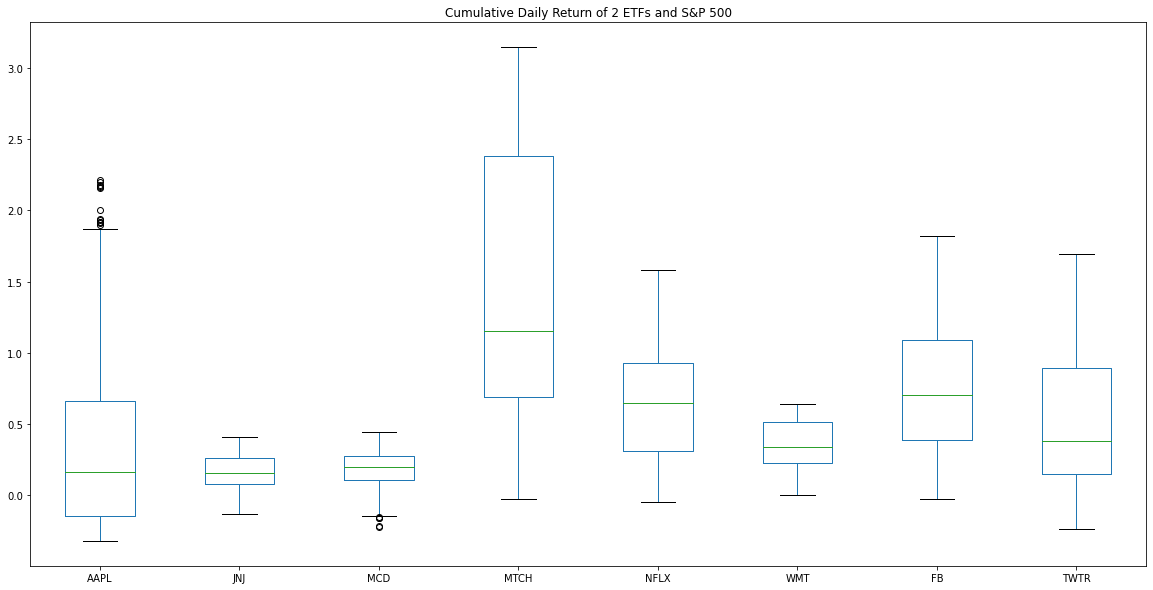

In [76]:
cum_daily_returns_df.plot(figsize=(20,10),kind='box' ,title="Cumulative Daily Return of 2 ETFs and S&P 500")

# Standard Deviation

In [77]:
df_daily_returns_dev= df_daily_returns.std()
df_daily_returns_dev.sort_values(ascending=True)
df_daily_returns_dev

AAPL    0.035170
JNJ     0.013726
MCD     0.016850
MTCH    0.030593
NFLX    0.024443
WMT     0.014144
FB      0.022446
TWTR    0.031951
dtype: float64

In [78]:
# Calculate and sort the annualized standard deviation (252 trading days) of the portfolio
# Review the annual standard deviations smallest to largest
df_daily_returns_dev_252 = df_daily_returns_dev*np.sqrt(252)
df_daily_returns_dev_252.sort_values(ascending=True)

JNJ     0.217895
WMT     0.224531
MCD     0.267488
FB      0.356321
NFLX    0.388025
MTCH    0.485646
TWTR    0.507204
AAPL    0.558300
dtype: float64

<AxesSubplot:title={'center':'Rolling 21 Day Daily Return of the Portfolio'}, xlabel='Date'>

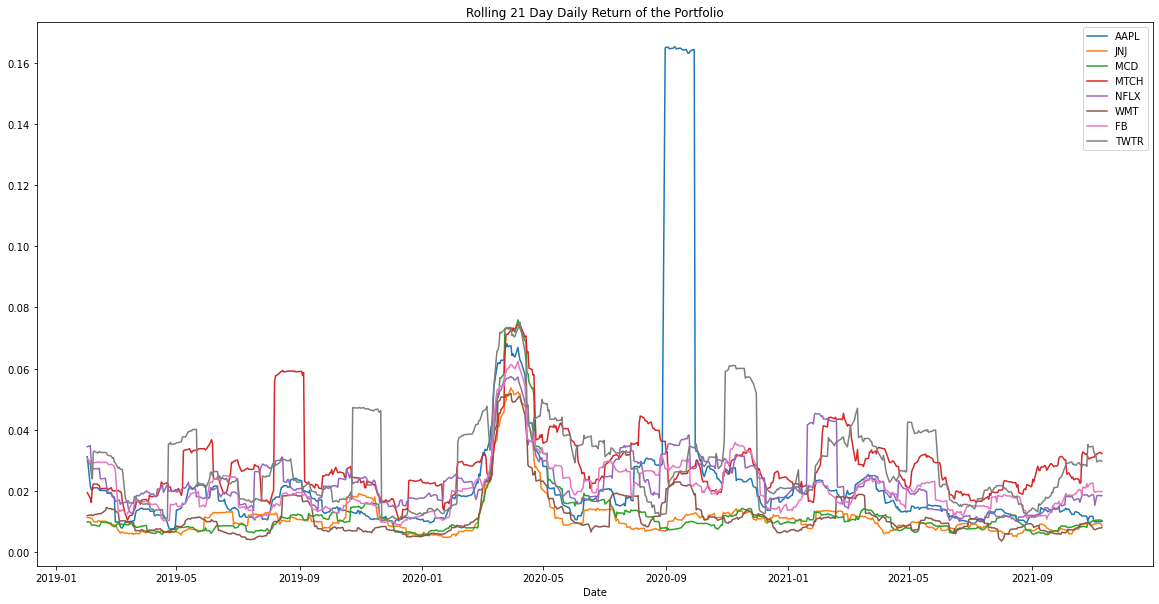

In [79]:
df_daily_returns_std_21=df_daily_returns.rolling(window=21).std()
df_daily_returns_std_21.dropna(inplace=True)
df_daily_returns_std_21.plot(figsize=(20,10),title="Rolling 21 Day Daily Return of the Portfolio")

In [80]:
# Calculate the annualized Returns
df_annual_returns=df_daily_returns.mean()*252
df_annual_returns.sort_values(ascending=True)

JNJ     0.110399
MCD     0.160557
WMT     0.189166
AAPL    0.254356
TWTR    0.347819
FB      0.377028
NFLX    0.386395
MTCH    0.569945
dtype: float64

In [81]:
# Calculate the annualized Sharpe Ratios for each of the portfolio
# Review the Sharpe ratios sorted lowest to highest
df_sharpe=df_annual_returns/df_daily_returns_dev_252
df_sharpe.sort_values(ascending=True)

AAPL    0.455590
JNJ     0.506664
MCD     0.600241
TWTR    0.685758
WMT     0.842496
NFLX    0.995797
FB      1.058111
MTCH    1.173580
dtype: float64

<AxesSubplot:title={'center':'Sharpe ratios for the portfolio'}>

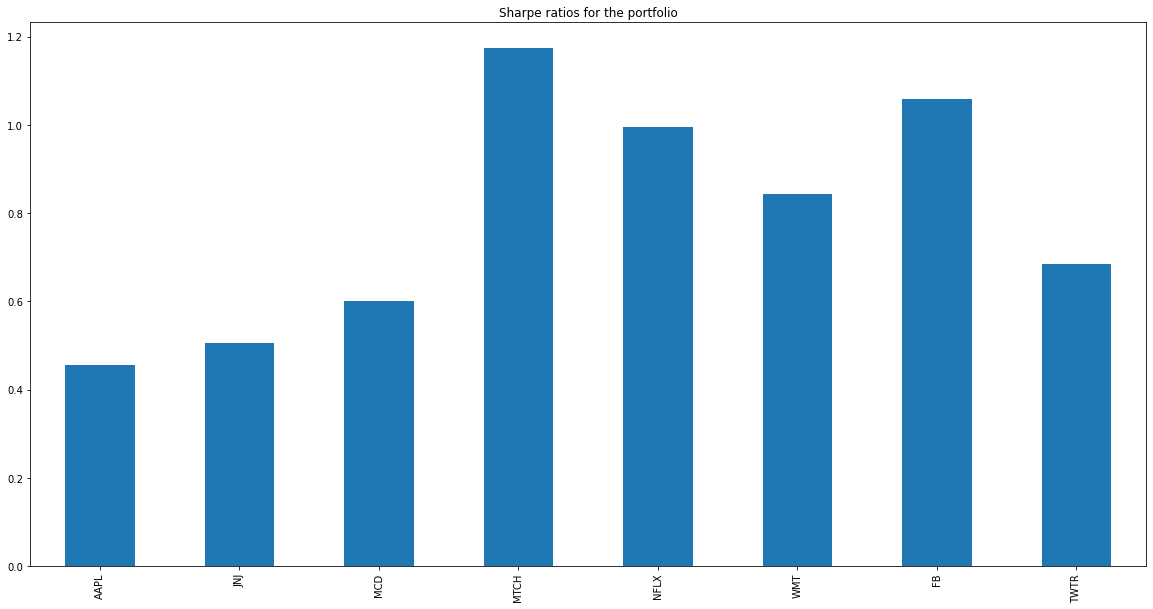

In [82]:
# Visualize the Sharpe ratios as a bar chart
df_sharpe.plot(kind='bar', figsize=(20,10), title='Sharpe ratios for the portfolio')

In [83]:
# Calculate the variance of the SPY using a rolling 60-day window.
df_spy_daily_returns = df_closing_prices['SPY'].pct_change()
df_spy_var=df_spy_daily_returns.rolling(window=60).var()
df_spy_var

Date
2019-01-02         NaN
2019-01-03         NaN
2019-01-04         NaN
2019-01-07         NaN
2019-01-08         NaN
                ...   
2021-11-04    0.000053
2021-11-05    0.000053
2021-11-08    0.000053
2021-11-09    0.000053
2021-11-10    0.000052
Name: SPY, Length: 722, dtype: float64

In [48]:
#Calculate Rolling Covariance 60 day

rolling_covariance_60day = df_daily_returns.rolling(window=60).cov(df_spy_daily_returns)

rolling_covariance_60day.tail()


weight_df = portfolio_df
for ticker in portfolio_tickers:
    weight_df = portfolio_df['Cost Basis']/portfolio_df['Cost Basis'].sum()

rolling_covariance_portfolio_60day = rolling_covariance_60day.dot(weight_df.to_list())

rolling_covariance_portfolio_60day

Date
2019-01-02         NaN
2019-01-03         NaN
2019-01-04         NaN
2019-01-07         NaN
2019-01-08         NaN
                ...   
2021-11-04    0.000045
2021-11-05    0.000045
2021-11-08    0.000045
2021-11-09    0.000045
2021-11-10    0.000044
Length: 722, dtype: float64

In [162]:
# Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
# Review the last five rows of the beta information
rolling_portfolio_beta=rolling_covariance_portfolio_60day/df_spy_var
rolling_portfolio_beta.tail()

Date
2021-11-03    0.861619
2021-11-04    0.861516
2021-11-05    0.861925
2021-11-08    0.862209
2021-11-09    0.864043
dtype: float64

In [163]:
# Calculate the average of the 60-day rolling beta
avg_rolling_portfolio_beta = rolling_portfolio_beta.mean()
avg_rolling_portfolio_beta

0.9328830394651684

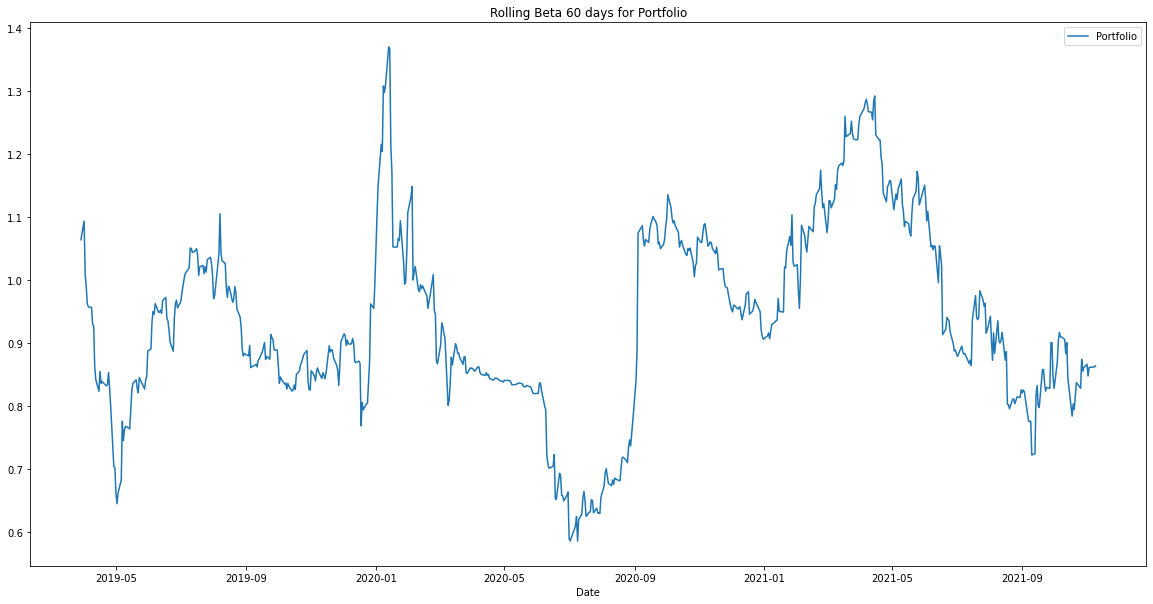

In [164]:
# Plot the rolling beta 
# Include a title parameter and adjust the figure size
ax = rolling_portfolio_beta.plot(figsize=(20,10), title='Rolling Beta 60 days for Portfolio')
ax.legend(["Portfolio"])

In [85]:
df_portfolio_ticker = df_ticker
df_portfolio_ticker.drop(columns=['SPY'], inplace=True)

In [86]:
# Set number of simulations
num_sims = 1000

# Configure a Monte Carlo simulation to forecast three years daily returns
MC_Portfolio = MCSimulation(
    portfolio_data = df_portfolio_ticker,
    #weights=[0.20, 0.20, 0.40, 0.20],
    weights=weight_df.to_list(),
    num_simulation = num_sims,
    num_trading_days = 252*3
)

In [87]:
MC_Portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003603,1.003249,0.991273,1.008983,0.993425,1.014723,0.999138,1.008392,1.005066,0.992628,...,0.989707,1.007213,1.012816,0.999502,1.002798,1.002168,1.015150,1.004270,0.995299,0.999442
2,1.004708,1.004639,0.997125,1.026366,0.998398,1.020797,1.015909,1.002773,1.025580,0.990164,...,0.992096,1.018828,1.024921,1.000227,0.994505,1.013897,1.015136,1.008583,1.000206,0.994348
3,0.985531,1.011959,0.993878,1.037171,1.009419,1.011394,1.017123,1.004183,1.024401,0.994429,...,0.996586,1.026971,1.016824,1.010109,1.021623,1.016888,1.013435,1.004113,1.014723,0.987141
4,0.985590,1.013029,0.987688,1.035967,1.012512,1.009825,1.003157,1.009264,1.015217,0.994759,...,0.988424,1.033844,1.027778,1.018760,1.036085,1.011244,1.009314,1.009251,1.014434,0.997618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2.593319,2.742354,2.142548,2.490521,2.384845,2.690474,2.524138,1.321316,1.891019,2.254005,...,2.483710,2.864784,2.440157,1.643804,3.339223,3.026597,2.184207,1.928162,2.379891,2.450130
753,2.617065,2.749997,2.140251,2.514326,2.420627,2.698899,2.539127,1.331243,1.916678,2.272341,...,2.466723,2.882814,2.434422,1.643702,3.411147,3.055245,2.167229,1.940045,2.391215,2.460342
754,2.626465,2.763589,2.127278,2.570202,2.389182,2.706368,2.536893,1.322493,1.882854,2.296627,...,2.516196,2.856904,2.453752,1.641005,3.455817,3.051527,2.164951,1.923807,2.398683,2.497061
755,2.652424,2.717885,2.129780,2.586671,2.411630,2.723744,2.569710,1.305964,1.898577,2.315483,...,2.519040,2.878972,2.421593,1.666351,3.444831,3.044114,2.176066,1.880163,2.369363,2.529110


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 756 Trading Days.'}>

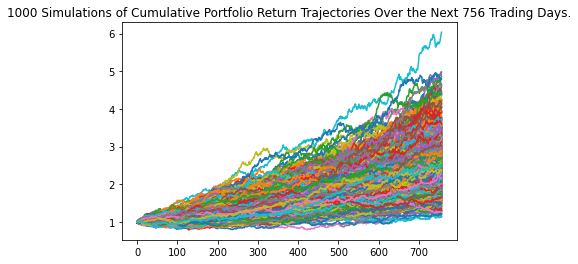

In [88]:
MC_Portfolio.plot_simulation()

In [89]:
simulated_returns_data = {
    "mean": list(MC_Portfolio.simulated_return.mean(axis=1)),
    "median": list(MC_Portfolio.simulated_return.median(axis=1)),
    "min": list(MC_Portfolio.simulated_return.min(axis=1)),
    "max": list(MC_Portfolio.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.001332,1.001301,0.970044,1.037226
2,1.002830,1.002923,0.963300,1.046768
3,1.004254,1.003978,0.955133,1.055205
4,1.005262,1.004443,0.946408,1.062677


In [90]:
df_simulated_data=MC_Portfolio.simulated_return
df_simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003603,1.003249,0.991273,1.008983,0.993425,1.014723,0.999138,1.008392,1.005066,0.992628,...,0.989707,1.007213,1.012816,0.999502,1.002798,1.002168,1.015150,1.004270,0.995299,0.999442
2,1.004708,1.004639,0.997125,1.026366,0.998398,1.020797,1.015909,1.002773,1.025580,0.990164,...,0.992096,1.018828,1.024921,1.000227,0.994505,1.013897,1.015136,1.008583,1.000206,0.994348
3,0.985531,1.011959,0.993878,1.037171,1.009419,1.011394,1.017123,1.004183,1.024401,0.994429,...,0.996586,1.026971,1.016824,1.010109,1.021623,1.016888,1.013435,1.004113,1.014723,0.987141
4,0.985590,1.013029,0.987688,1.035967,1.012512,1.009825,1.003157,1.009264,1.015217,0.994759,...,0.988424,1.033844,1.027778,1.018760,1.036085,1.011244,1.009314,1.009251,1.014434,0.997618


In [91]:
# Set initial investment
initial_investment = portfolio_df['Cost Basis'].sum()

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns

# Display sample data
cumulative_pnl.head()

,mean,median,min,max
0,145906.000000,145906.000000,145906.000000,145906.000000
1,146100.376817,146095.755242,141535.181996,151337.532748
2,146318.852070,146332.544691,140551.295015,152729.685062
3,146526.749555,146486.440513,139359.692803,153960.715339
4,146673.797066,146554.260444,138086.563552,155050.970273


<AxesSubplot:title={'center':'Simulated Outcomes Behavior of the Portfolio Over the Next 3 Years'}>

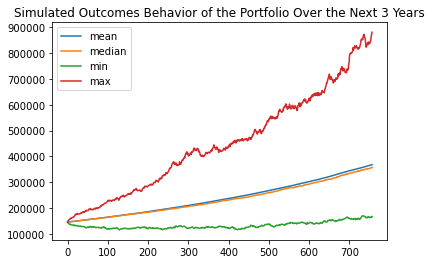

In [92]:
cumulative_pnl.plot(title="Simulated Outcomes Behavior of the Portfolio Over the Next 3 Years")

In [93]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_Portfolio.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           1000.000000
mean               2.523288
std                0.670789
min                1.146969
25%                2.043878
50%                2.444589
75%                2.906447
max                6.033474
95% CI Lower       1.483952
95% CI Upper       4.059954
Name: 756, dtype: float64


In [94]:
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower:,.2f} and ${ci_upper:,.2f}.")

There is a 95% chance that an initial investment of $145,906.00 in the portfolio over the next year will end within in the range of $216,517.51 and $592,371.60.


In [111]:
merged_portfolio_sp_YTD.reset_index(inplace=True)

# YTD Charts

In [112]:
# Ploty is an outstanding resource for interactive charts.

trace1 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Share YTD'][0:10],
    name = 'Ticker YTD')

trace2 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SPY YTD'][0:10],
    name = 'SPY YTD')
    
data1 = [trace1, trace2]

layout1 = go.Layout(title = 'YTD Return vs SPY YTD'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.8,y=1)
    ,height=800, width=1600
    )

fig1 = go.Figure(data=data1, layout=layout1)

# Total Return Comparison Charts

In [113]:
trace3 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Ticker Return'][0:10],
    name = 'Ticker Total Return')

trace4 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SP Return'][0:10],
    name = 'SP500 Total Return')
    
data2 = [trace3, trace4]

layout2 = go.Layout(title = 'Total Return vs S&P 500'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker', tickformat=".2%")
    , legend=dict(x=.8,y=1)
    ,height=800, width=1600
    )

fig2 = go.Figure(data=data2, layout=layout2)

# 

In [114]:
trace5 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Stock Gain / (Loss)'][0:10],
    name = 'Ticker Total Return ($)')

trace6 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SPY Gain / (Loss)'][0:10],
    name = 'SPY Total Return ($)')

trace7 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Ticker Return'][0:10],
    name = 'Ticker Total Return %',
    yaxis='y2')

data3 = [trace5, trace6, trace7]

layout3 = go.Layout(title = 'Gain / (Loss) Total Return vs SPY'
    , barmode = 'group'
    , yaxis=dict(title='Gain / (Loss) ($)')
    , yaxis2=dict(title='Ticker Return', overlaying='y', side='right', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.75,y=1)
    ,height=800, width=1600
    )

fig3 = go.Figure(data=data3, layout=layout3)

In [115]:
trace8 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Invst'],
    # mode = 'lines+markers',
    name = 'Cum Invst')

trace9 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum SP Returns'],
    # mode = 'lines+markers',
    name = 'Cum SP500 Returns')

trace10 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Ticker Returns'],
    # mode = 'lines+markers',
    name = 'Cum Ticker Returns')

trace11 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Ticker ROI Mult'],
    # mode = 'lines+markers',
    name = 'Cum ROI Mult'
    , yaxis='y2')


data4 = [trace8, trace9, trace10, trace11]

layout4 = go.Layout(title = 'Total Cumulative Investments Over Time'
    , barmode = 'group'
    , yaxis=dict(title='Returns')
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.4,y=1)
    , yaxis2=dict(title='Cum ROI Mult', overlaying='y', side='right')  
    ,height=800, width=1600
    )

fig4 = go.Figure(data=data4, layout=layout4)

In [116]:
fig5 = px.line(df_daily_returns, title='<b>Daily Returns<b>',
                      labels={"value": "Daily Returns"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

In [117]:
fig6 = px.box(cum_daily_returns_df, title = '<b>Cumulative  Returns<b>'
              ,height=800, width=1600
        )

In [118]:
fig7 = px.line(df_daily_returns_std_21,title='<b>Rolling 21 Day Returns<b>',
                      labels={"value": "Daily Returns"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

In [119]:
fig8= px.bar(df_sharpe,title='<b>Sharpe Ratio<b>',
                      labels={"value": "Sharpe Ratio"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

In [120]:
fig9 = px.line(rolling_portfolio_beta,title='<b>Rolling 60 Day Beta<b>',
                      labels={"value": "Beta"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

NameError: name 'rolling_portfolio_beta' is not defined

In [121]:
fig_simulated_returns = px.line(df_simulated_data, 
                          title='<b>Simulated Returns<b>',
                          labels={"value": "Returns"}
                          ,height=800, width=1600
                         )

In [122]:
fig_simulated_cum_pnl = px.line(cumulative_pnl, 
                          title='<b>Simulated Cumulative P&L<b>',
                          labels={"value": "Returns"}
                          ,height=800, width=1600
                         )

In [110]:
app = dash.Dash()

app.layout = html.Div( children=[
    html.H1(children='Portfolio Analysis Dashboard',style={
            'textAlign': 'center'})
    ,html.H2(children='''
        All your Portfolio Analysis in one place
    ''')
    ,html.H2(children=
        f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
        f" over the next three years will end within in the range of"
        f" ${ci_lower:,.2f} and ${ci_upper:,.2f}."
    )
    
    
    
    
    ,dcc.Graph(id="YTD Summary", figure=fig1)
    ,dcc.Graph(id="Total Return", figure=fig2)
    ,dcc.Graph(id="Total Cumulative Return", figure=fig3)
    ,dcc.Graph(id="Total Cumulative ROI", figure=fig4)
    ,dcc.Graph(id="Daily Returns", figure=fig5)
    ,dcc.Graph(id="Cumulative Returns", figure=fig6)
    ,dcc.Graph(id="Rolling 21 Day Returns", figure=fig7)
    ,dcc.Graph(id="Sharpe Ratio", figure=fig8)
    ,dcc.Graph(id="Rolling 60 Day Beta", figure=fig9)
    ,dcc.Graph(id="Simulated Returns", figure=fig_simulated_returns)
    ,dcc.Graph(id="Simulated Cumulative P&L", figure=fig_simulated_cum_pnl)
    
    #,dcc.Graph(id="YOY Summary", figure=fig_year_summary)
    ##,dcc.Graph(id="Daily Volume", figure=fig_vol)
    #,dcc.Graph(id="Daily Returns", figure=fig_returns)
    #,dcc.Graph(id="Cumulative Daily Returns", figure=fig_cum_returns)
    #,dcc.Graph(id="Cumulative BTC Daily Returns", figure=fig_cum_btc_returns)
    #,dcc.Graph(id="Rolling 21 Day Daily Returns", figure=fig_daily_returns_std_21)
    #,dcc.Graph(id="Sharpe Ratio", figure=fig_sharpe_ratio)
    
    ##,dcc.Graph(id="Daily Returns and Volume", figure=fig)
])

if __name__ == "__main__":
    #app.run_server(debug=True)
    app.run_server( port = 8096, dev_tools_ui=True, #debug=True,
              dev_tools_hot_reload =True, threaded=True)




NameError: name 'fig9' is not defined